In [38]:
import numpy as np
import struct
from array import array
from os.path import join
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt


class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath, batch_size=64):
        self.batch_size = batch_size
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

        # Load data and create DataLoader for training dataset
        (x_train, y_train), (_, _) = self.load_data()
        train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).long())
        self.trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)

        # Convert to PyTorch tensors and normalize
        x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) / 255.0
        x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1) / 255.0

        return (x_train, y_train), (x_test, y_test)


In [39]:

# Set file paths based on added MNIST Datasets
input_path = '../input'
training_images_filepath = join(input_path, 'C:/Users/DELL/Downloads/archive (5)/train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'C:/Users/DELL/Downloads/archive (5)/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 'C:/Users/DELL/Downloads/archive (5)/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 'C:/Users/DELL/Downloads/archive (5)/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Load MNIST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize=15)
        index += 1



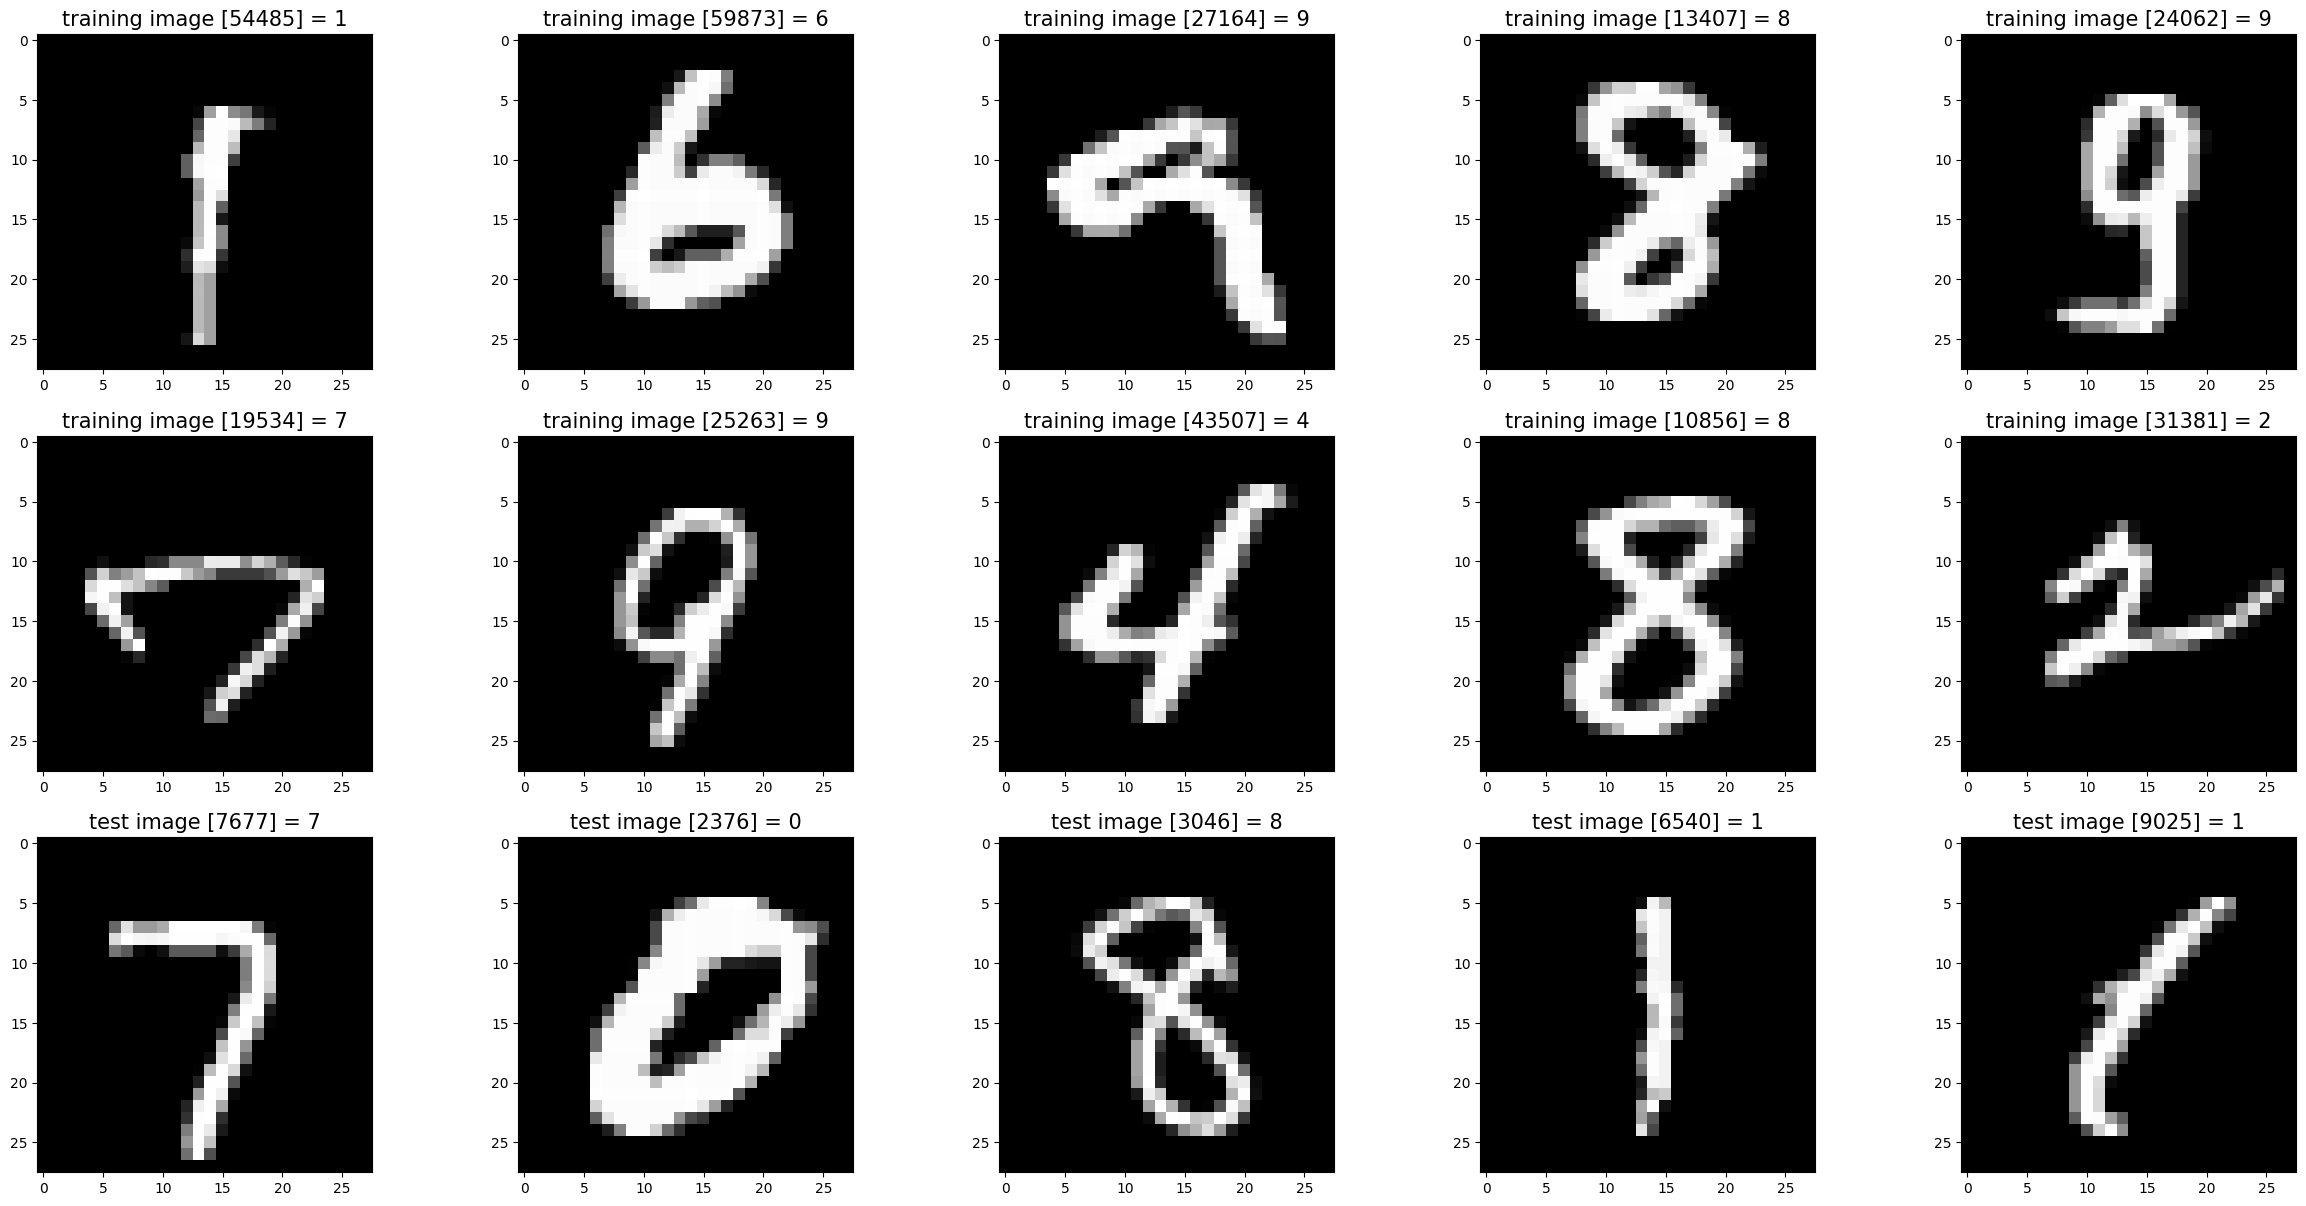

In [40]:
# Show some random training and test images 
import random
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r].squeeze().numpy())
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r].squeeze().numpy())        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [41]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Adjusted the number of input channels to 1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
# Instantiate the network, criterion, and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [46]:
# Training loop
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(mnist_dataloader.trainloader, 0):
        inputs, labels = data

        # Ensure correct input shape
        
        #inputs = inputs.squeeze(1)


        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


print('Finished Training')

Finished Training


In [49]:
from torchvision import datasets

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test dataset
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)


100%|██████████| 9912422/9912422 [00:04<00:00, 2049115.60it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28766491.05it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5308902.53it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4547750.96it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [50]:
# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation during testing
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy on the test set
accuracy = correct / total
print('Accuracy on the test set: {:.2%}'.format(accuracy))

Accuracy on the test set: 78.51%


In [51]:
# Assuming you have already trained the network and have a trained model 'net'

# Set the model to evaluation mode
net.eval()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in range(10)}  # Assuming you have 10 classes (for MNIST)
total_pred = {classname: 0 for classname in range(10)}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname} is {accuracy:.1f} %')


Accuracy for class 0 is 86.4 %
Accuracy for class 1 is 98.5 %
Accuracy for class 2 is 76.8 %
Accuracy for class 3 is 84.8 %
Accuracy for class 4 is 88.2 %
Accuracy for class 5 is 81.5 %
Accuracy for class 6 is 71.1 %
Accuracy for class 7 is 92.3 %
Accuracy for class 8 is 38.8 %
Accuracy for class 9 is 63.0 %
